In [1]:
# HIDE
import pandas as pd
import numpy as np
np.random.seed(7)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white", palette="muted", color_codes=True, context="talk")
from IPython import display
%matplotlib inline

import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight

import keras as ke
import keras.backend as K
from keras.layers import Input, Dense, Dropout
from keras.models import Model
from keras.models import load_model


create_gif = False

# model reconstruction from JSON:
from keras.models import model_from_json

print(f"sklearn: {sk.__version__}")
print(f"pandas: {pd.__version__}")
print(f"kerads: {ke.__version__}")


import src.my_functions_product1 as myFC
import matplotlib.pyplot as plt

Using TensorFlow backend.


sklearn: 0.19.1
pandas: 0.23.0
kerads: 2.1.6


In [2]:
feature_path = 'Feature-Datasets/adult/'
data_filename = 'adult.data'

#feature_path = 'Feature-Datasets/bank/'
#data_filename = 'bank.csv'

## Input your architecture and trained model

In [3]:
user_main_json_text_file,user_adv_json_text_file,h5_filename,result_fname,train_or_untrain = myFC.user_model_arch_feature_input(feature_path,data_filename)

Enter text filename to read your json string for your main architecture file:user1_main_task_arch_json_string_file.txt
Enter text filename to read your json string for your adv architecture file:user1_adv_task_arch_json_string_file.txt
As for model, do you want to just upload the untrained architecture or the trained model? Please enter 'trained' or 'untrained'trained
Trained or untrained : 'trained'
-----------------------------------

Enter your .h5 filename: user1_main_task_ori_trained_model.h5


In [ ]:
#user1_main_task_arch_json_string_file.txt
#user1_adv_task_arch_json_string_file.txt
#user1_main_task_ori_trained_model.h5

## Reading the json files for main task and adversary

In [4]:
main_task_arch_json_string = myFC.read_txt_file_to_string(user_main_json_text_file)
adv_task_arch_json_string = myFC.read_txt_file_to_string(user_adv_json_text_file)

## Feature Reading

In [5]:
X_train, Z_train, y_train = myFC.feature_file_reading(feature_path,'train')
X_test, Z_test, y_test = myFC.feature_file_reading(feature_path,'test')

## Model and compile only main task: check prediction results

In [6]:
save_the_weights = (train_or_untrain == 'untrained')
main_task_accuracy, p_rule_for_Y1, y_pred = myFC.pre_train_main_task(main_task_arch_json_string,X_train, y_train,X_test,y_test,Z_test,save_the_weights=save_the_weights,h5_file_name=h5_filename)

Accuracy: 85.20


## Combining the main task arch with the adversarial arch

### Train using pre-trained weights of main model

In [7]:
tradeoff_lambda_v = [0,1,2,3,4,5,6,7,8,9,10]  
pre_load_flag = True
main_task_trained_weight_file = h5_filename

for tradeoff_lambda in tradeoff_lambda_v:
    print('tradeoff_lambda = ', tradeoff_lambda)
    # initialise FairClassifier
    clf = myFC.FairClassifier(tradeoff_lambda=tradeoff_lambda,
                     main_task_arch_json_string=main_task_arch_json_string,
                     adv_task_arch_json_string=adv_task_arch_json_string,
                     pre_load_flag=pre_load_flag,main_task_trained_weight_file=main_task_trained_weight_file)
    
    # pre-train both adverserial and classifier networks
    clf.pretrain(X_train, y_train, Z_train, verbose=0, epochs=5,pre_load_flag=pre_load_flag,main_task_trained_weight_file=main_task_trained_weight_file)
    before_main_task_accuracy, before_p_rule_for_Y1,before_y_pred = myFC.bias_accuracy_performance(X_test,y_test,Z_test,clf)
    
    # adverserial train on train set and validate on test set
    clf.fit(X_train, y_train, Z_train, 
            validation_data=(X_test, y_test, Z_test),
            T_iter=165, save_figs=create_gif)
    after_main_task_accuracy, after_p_rule_for_Y1,after_y_pred = myFC.bias_accuracy_performance(X_test,y_test,Z_test,clf)
    
    
    result_fname_y_pred_before_after,result_fname_acc_p_before_after = myFC.saving_performance_result(before_main_task_accuracy, before_p_rule_for_Y1,before_y_pred, after_main_task_accuracy, after_p_rule_for_Y1,after_y_pred,tradeoff_lambda,result_fname)


tradeoff_lambda =  0
Accuracy: 85.39
Accuracy: 85.35
tradeoff_lambda =  1
Accuracy: 85.39
Accuracy: 85.28
tradeoff_lambda =  2
Accuracy: 85.39
Accuracy: 84.80
tradeoff_lambda =  3
Accuracy: 85.39
Accuracy: 84.39
tradeoff_lambda =  4
Accuracy: 85.39
Accuracy: 84.12
tradeoff_lambda =  5
Accuracy: 85.39
Accuracy: 83.96
tradeoff_lambda =  6
Accuracy: 85.39
Accuracy: 83.60
tradeoff_lambda =  7
Accuracy: 85.39
Accuracy: 83.67
tradeoff_lambda =  8
Accuracy: 85.39
Accuracy: 83.51
tradeoff_lambda =  9
Accuracy: 85.39
Accuracy: 83.15
tradeoff_lambda =  10
Accuracy: 85.39
Accuracy: 83.54


## Reading the result files

### Accuracy & p-score trade-off curves

In [8]:
tradeoff_lambda_v = [0,1,2,3,4,5,6,7,8,9,10]  
Bacc_Bp_Aacc_Ap_results = np.zeros([len(tradeoff_lambda_v),4])

for item in range(len(tradeoff_lambda_v)):
    
    tradeoff_lambda = tradeoff_lambda_v[item]
    result_fname_acc_p_before_after = result_fname +'Result_acc_p_BA_' + 'L'+ str(tradeoff_lambda)+'.txt'
    Bacc_Bp_Aacc_Ap = np.loadtxt(result_fname_acc_p_before_after, delimiter=',')
    Bacc_Bp_Aacc_Ap_results[item, :] = Bacc_Bp_Aacc_Ap

Text(0.5,1,'Trade off')

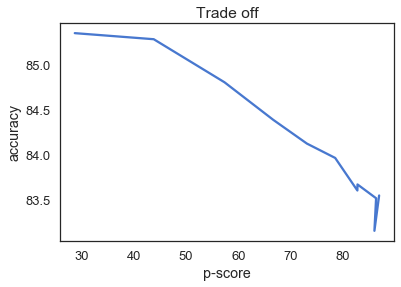

In [9]:
plt.plot(Bacc_Bp_Aacc_Ap_results[:,3], 100*Bacc_Bp_Aacc_Ap_results[:,2])
plt.xlabel('p-score')
plt.ylabel('accuracy')
plt.title('Trade off')

### y_pred distribution curves

In [10]:
result_fname_y_pred_before_after = result_fname + 'Result_y_pred_'+'L' + str(tradeoff_lambda) +'.txt'
BA_y_pred = np.loadtxt(result_fname_y_pred_before_after, delimiter=',')

#### Before the de-biaser

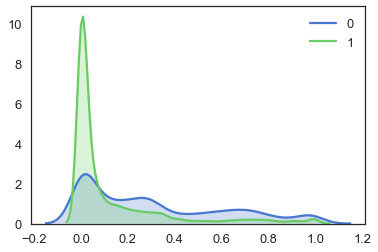

In [11]:
ax = sns.distplot(BA_y_pred[Z_test == 0,0], hist=False, 
                  kde_kws={'shade': True,},
                  label='{}'.format('0'))

ax = sns.distplot(BA_y_pred[Z_test == 1,0], hist=False, 
                  kde_kws={'shade': True,},
                  label='{}'.format('1'))

#### After the de-biaser

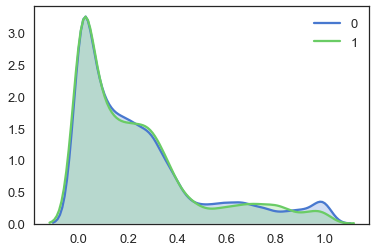

In [12]:
ax = sns.distplot(BA_y_pred[Z_test == 0,1], hist=False, 
                  kde_kws={'shade': True,},
                  label='{}'.format('0'))

ax = sns.distplot(BA_y_pred[Z_test == 1,1], hist=False, 
                  kde_kws={'shade': True,},
                  label='{}'.format('1'))